In [68]:
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import class_weight, resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report

In [69]:
df_treino = pd.read_csv("desafio_manutencao_preditiva_treino.csv")
df_teste = pd.read_csv("desafio_manutencao_preditiva_teste.csv")

# Pré-Processamento dos Dados

Muitos algoritmos preditivos esperam receber os dados padronizados e codificados. Portanto, é necessário transformar os dados para adequá-los aos modelos.

In [70]:
# separando as variáveis em ids, categóricas e numéricas
ids = ['udi', 'product_id']
categorical = ['type', 'failure_type']
numerical = [col for col in df_treino.columns if col not in ids and col not in categorical]

## Encoding das variáveis categóricas

In [71]:
# Número de classes das variáveis categóricas
df_treino[categorical].nunique()

type            3
failure_type    6
dtype: int64

A variável type possui apenas 3 classes, vamos aplicar a técnica de OneHotEncoding para sua codificação, já a variável target failure_type possui 6 classes distintas. Para que não ocorra um grande aumento de dimensionalidade, vamos aplicar LabelEncoding.

In [72]:
# OneHotEncoding
df_treino_enc = pd.get_dummies(df_treino, columns=['type'])
df_treino_enc

,udi,product_id,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,type_H,type_L,type_M
0,1,M14860,298.1,308.6,1551,42.8,0,No Failure,0,0,1
1,2,L47181,298.2,308.7,1408,46.3,3,No Failure,0,1,0
2,5,L47184,298.2,308.7,1408,40.0,9,No Failure,0,1,0
3,6,M14865,298.1,308.6,1425,41.9,11,No Failure,0,0,1
4,7,L47186,298.1,308.6,1558,42.4,14,No Failure,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6662,9995,L57174,298.8,308.3,1634,27.9,12,No Failure,0,1,0
6663,9996,M24855,298.8,308.4,1604,29.5,14,No Failure,0,0,1
6664,9997,H39410,298.9,308.4,1632,31.8,17,No Failure,1,0,0
6665,9999,H39412,299.0,308.7,1408,48.5,25,No Failure,1,0,0


In [73]:
# Label Encoding
le = LabelEncoder()
df_treino_enc['failure_type'] = le.fit_transform(df_treino_enc['failure_type'])
df_treino_enc

,udi,product_id,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,type_H,type_L,type_M
0,1,M14860,298.1,308.6,1551,42.8,0,1,0,0,1
1,2,L47181,298.2,308.7,1408,46.3,3,1,0,1,0
2,5,L47184,298.2,308.7,1408,40.0,9,1,0,1,0
3,6,M14865,298.1,308.6,1425,41.9,11,1,0,0,1
4,7,L47186,298.1,308.6,1558,42.4,14,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6662,9995,L57174,298.8,308.3,1634,27.9,12,1,0,1,0
6663,9996,M24855,298.8,308.4,1604,29.5,14,1,0,0,1
6664,9997,H39410,298.9,308.4,1632,31.8,17,1,1,0,0
6665,9999,H39412,299.0,308.7,1408,48.5,25,1,1,0,0


## Padronização e normalização das variáveis numéricas

Os dados podem ser padronizados ou normalizados. A padronização consiste em deixá-los numa distribuição normal com média 0 e desvio padrão 1. Já a normalização trata de deixar os dados numa escala única, geralmente de 0 a 1 ou de -1 a 1. 

Para os dados cuja distribuição não é gaussiana (ou normal), a normalização geralmente é uma melhor opção.

Para os dados nesse problema, será aplicada a padronização para as variáveis numéricas cuja distribuição é normal e a normalização para a variável tool_wear_min que tem uma distribuição uniforme.

In [74]:
scale = [col for col in numerical if col != 'tool_wear_min']
scaler = StandardScaler()
df_treino_enc[scale] = scaler.fit_transform(df_treino_enc[scale])

In [75]:
df_treino_enc

,udi,product_id,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,type_H,type_L,type_M
0,1,M14860,-0.948838,-0.935907,0.076652,0.275525,0,1,0,0,1
1,2,L47181,-0.898702,-0.868702,-0.730484,0.627282,3,1,0,1,0
2,5,L47184,-0.898702,-0.868702,-0.730484,-0.005881,9,1,0,1,0
3,6,M14865,-0.948838,-0.935907,-0.634531,0.185073,11,1,0,0,1
4,7,L47186,-0.948838,-0.935907,0.116163,0.235324,14,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6662,9995,L57174,-0.597884,-1.137521,0.545130,-1.221954,12,1,0,1,0
6663,9996,M24855,-0.597884,-1.070317,0.375801,-1.061151,14,1,0,0,1
6664,9997,H39410,-0.547747,-1.070317,0.533841,-0.829996,17,1,1,0,0
6665,9999,H39412,-0.497611,-0.868702,-0.730484,0.848386,25,1,1,0,0


In [76]:
normalize = ['tool_wear_min']
normalizer = MinMaxScaler()
df_treino_enc[normalize] = normalizer.fit_transform(df_treino_enc[normalize])
df_treino_enc

,udi,product_id,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,type_H,type_L,type_M
0,1,M14860,-0.948838,-0.935907,0.076652,0.275525,0.000000,1,0,0,1
1,2,L47181,-0.898702,-0.868702,-0.730484,0.627282,0.011952,1,0,1,0
2,5,L47184,-0.898702,-0.868702,-0.730484,-0.005881,0.035857,1,0,1,0
3,6,M14865,-0.948838,-0.935907,-0.634531,0.185073,0.043825,1,0,0,1
4,7,L47186,-0.948838,-0.935907,0.116163,0.235324,0.055777,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6662,9995,L57174,-0.597884,-1.137521,0.545130,-1.221954,0.047809,1,0,1,0
6663,9996,M24855,-0.597884,-1.070317,0.375801,-1.061151,0.055777,1,0,0,1
6664,9997,H39410,-0.547747,-1.070317,0.533841,-0.829996,0.067729,1,1,0,0
6665,9999,H39412,-0.497611,-0.868702,-0.730484,0.848386,0.099602,1,1,0,0


Na análise exploratória, vimos que as variáveis rotational_speed_rpm e torque_nm possuíam valores _outliers_, vamos verificar agora quantos valores desse existem no dataset de treino.

In [77]:
# União de todas as linhas onde uma das duas variáveis possui um outlier
outliers = pd.merge(df_treino_enc.loc[abs(df_treino_enc['rotational_speed_rpm']) > 3],
                    df_treino_enc.loc[abs(df_treino_enc['torque_nm']) > 3],
                    how='outer')
outliers

,udi,product_id,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,type_H,type_L,type_M
0,299,H29712,-1.049111,-1.003112,3.339063,-2.146572,0.501992,1,1,0,0
1,306,L47485,-1.099247,-1.070317,3.339063,-2.096321,0.589641,1,0,1,0
2,345,M15204,-1.249656,-1.204726,5.139597,-2.639031,0.115538,1,0,0,1
3,381,L47560,-1.249656,-1.137521,5.794337,-2.739533,0.505976,3,0,1,0
4,419,L47598,-1.299793,-1.070317,3.463238,-2.247074,0.000000,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
112,6526,L53705,0.555252,0.273778,-1.272337,3.370984,0.195219,3,0,1,0
113,7570,L54749,0.104025,0.677007,-1.594063,3.190081,0.593625,3,0,1,0
114,7764,L54943,0.204298,1.080236,-1.904500,3.672490,0.011952,3,0,1,0
115,8583,M23442,-1.249656,-1.271931,-1.148163,3.210181,0.601594,3,0,0,1


In [78]:
# Proporção de outliers
len(outliers)/len(df_treino_enc)

0.017549122543872805

Como a proporção de outliers é de menos de 2%, não há grande prejuízo em apenas remover essas linhas para que elas não comprometam o treinamento do modelo. 

In [79]:
df_treino_sem_outliers = df_treino_enc.loc[abs(df_treino_enc['rotational_speed_rpm']) < 3]
df_treino_sem_outliers = df_treino_sem_outliers.loc[abs(df_treino_sem_outliers['torque_nm']) < 3]
df_treino_sem_outliers

,udi,product_id,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,type_H,type_L,type_M
0,1,M14860,-0.948838,-0.935907,0.076652,0.275525,0.000000,1,0,0,1
1,2,L47181,-0.898702,-0.868702,-0.730484,0.627282,0.011952,1,0,1,0
2,5,L47184,-0.898702,-0.868702,-0.730484,-0.005881,0.035857,1,0,1,0
3,6,M14865,-0.948838,-0.935907,-0.634531,0.185073,0.043825,1,0,0,1
4,7,L47186,-0.948838,-0.935907,0.116163,0.235324,0.055777,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6662,9995,L57174,-0.597884,-1.137521,0.545130,-1.221954,0.047809,1,0,1,0
6663,9996,M24855,-0.597884,-1.070317,0.375801,-1.061151,0.055777,1,0,0,1
6664,9997,H39410,-0.547747,-1.070317,0.533841,-0.829996,0.067729,1,1,0,0
6665,9999,H39412,-0.497611,-0.868702,-0.730484,0.848386,0.099602,1,1,0,0


## Divisão do dataset em treino e validação

Como os dados de teste não possuem a variável target, é importante que separemos uma parte do dataset de treino para validar o modelo e garantir que não haja overfitting. Dividiremos então o dataset em treino e validação. Usaremos 25% dos dados para validação.

In [80]:
# Separa X e y
target = 'failure_type'
variables = ['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 'torque_nm', 'tool_wear_min', 'type_H', 
             'type_L', 'type_M']

y = df_treino_sem_outliers[target]
X = df_treino_sem_outliers[variables]

# Divisão em Dados de Treino e Validação.
X_treino, X_val, y_treino, y_val = train_test_split(X, y, test_size = 0.25, random_state = 101)

## Balanceamento das classes da variável target

A última etapa do pré-processamento é balancear as instâncias da variável target. Como visto na Análise Exploratória, há muito mais máquinas sem falhas do que com os 5 tipos de falhas apresentados. Se o modelo preditivo for alimentado dessa forma, ele aprenderá muito melhor sobre máquinas sem falhas do que sobre máquinas com falhas, portanto, é preciso aplicar alguma técnica de balanceamento de classes.

Pode-se aplicar o _oversampling_, que cria mais registros das classes que minoritárias ou o _undersampling_, que remove registros das classes majoritárias. 

O dataset possui poucos registros - apenas cerca de 6,5 mil - portanto, se aplicado o _undersampling_, teremos ainda menos dados para o treinamento e perderemos características demais sobre os dados.

O _oversampling_ também não funcionaria muito bem para esse modelo, visto que a diferença entre as classes é tão grande que seriam criados registros artificias demais para resolver a diferença.

A abordagem que faremos será a de converter o problema de classificação multiclasse em um problema de classificação binário, respondendo a pergunta: "Há ou não falha nas máquinas?". Após respondido esse primeiro questionamento, abordaremos então, para as máquinas em que há falha, qual o tipo de falha presente.

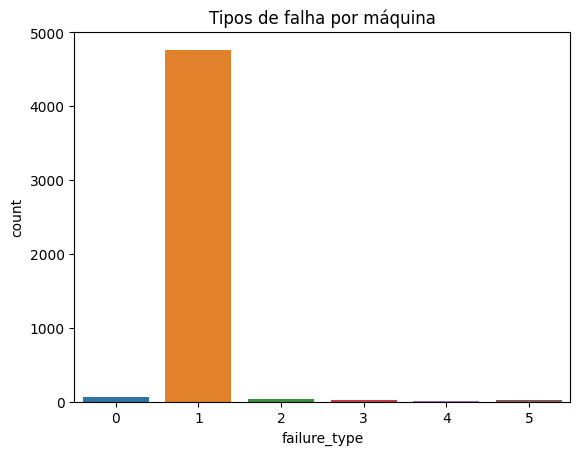

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x=y_treino)
plt.title('Tipos de falha por máquina');

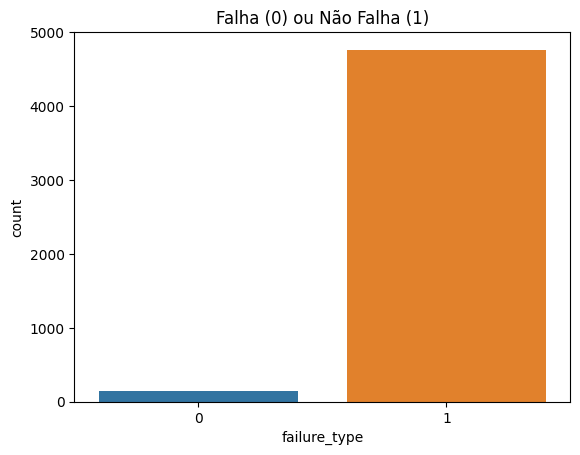

In [82]:
# Definindo o y_treino binário - falha ou não falha
y_treino_bin, y_val_bin = y_treino.where(y_treino == 1, 0), y_val.where(y_val == 1, 0)

# Plot
sns.countplot(x=y_treino_bin)
plt.title('Falha (0) ou Não Falha (1)');

In [83]:
# Cria o objeto balanceador
smote = SMOTE(random_state = 101)

# Aplica o balanceador
X_res, y_res = smote.fit_resample(X_treino, y_treino_bin)

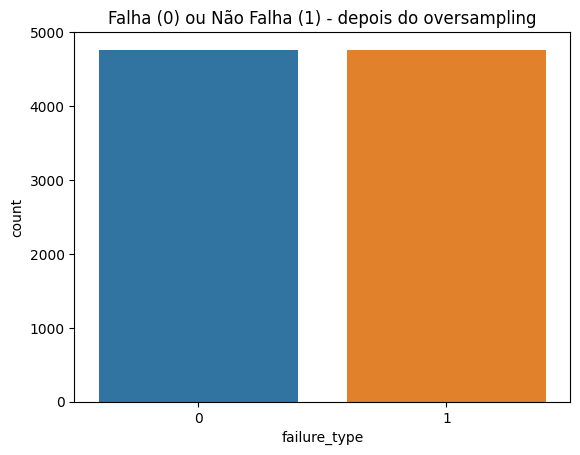

In [84]:
sns.countplot(x=y_res)
plt.title('Falha (0) ou Não Falha (1) - depois do oversampling');

# Criação do Modelo Preditivo - Classificação Binária

Após toda a etapa de Análise Exploratória e Pré-Processamento de Dados, podemos finalmente começar a criar e avaliar os modelos preditivos para esse problema. Como o problema é para prever uma classe, um tipo de falha, então é um problema de classificação. Mais especificamente, classificação multiclasse, visto que a variável target possui mais de 2 classes possíveis. No entanto, como mencionado anteriormente, primeiro transformaremos essa classificação multiclasse em classificação binária, e depois faremos a mudança para classificação multiclasse apenas daquelas máquinas em que uma falha for prevista.

Entre os algoritmos mais comuns para esse tipo de problema estão:
Regressão Logística, KNN, Naive Bayes, Decision Tree, SVM (Support Vector Machines) e Redes Neurais.

Criaremos alguns modelos e utilizaremos algumas métricas de avaliação.

In [85]:
# Cria o modelo
modelo_v1 = KNeighborsClassifier()

# Treinamento
start = time.time()
modelo_v1.fit(X_res, y_res)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

# Fazendo previsões para o conjunto de validação
previsoes_v1 = modelo_v1.predict(X_val)

# Avaliação do modelo
# Dicionário de métricas e metadados
dict_v1 = {'Modelo':'KNN',
           'Versão':'1',
           'Precision':precision_score(previsoes_v1, y_val_bin),
           'Recall':recall_score(previsoes_v1, y_val_bin),
           'F1 Score':f1_score(previsoes_v1, y_val_bin),
           'Acurácia':accuracy_score(previsoes_v1, y_val_bin)}

# Matrix de confusão
print('\n     Matriz de confusão')
print(confusion_matrix(y_val_bin, previsoes_v1))

Tempo de Treinamento do Modelo: 0.029993534088134766

     Matriz de confusão
[[  34   19]
 [ 101 1484]]


In [86]:
# Cria o modelo
modelo_v2 = GaussianNB()

# Treinamento
start = time.time()
modelo_v2.fit(X_res, y_res)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

# Fazendo previsões para o conjunto de validação
previsoes_v2 = modelo_v2.predict(X_val)

# Avaliação do modelo
dict_v2 = {'Modelo':'Naive Bayes',
           'Versão':'2',
           'Precision':precision_score(previsoes_v2, y_val_bin),
           'Recall':recall_score(previsoes_v2, y_val_bin),
           'F1 Score':f1_score(previsoes_v2, y_val_bin),
           'Acurácia':accuracy_score(previsoes_v2, y_val_bin)}

# Matrix de confusão
print('\n     Matriz de confusão')
print(confusion_matrix(y_val_bin, previsoes_v2))

Tempo de Treinamento do Modelo: 0.005003929138183594

     Matriz de confusão
[[  43   10]
 [ 401 1184]]


In [87]:
# Cria o modelo
modelo_v3 = DecisionTreeClassifier()

# Treinamento
start = time.time()
modelo_v3.fit(X_res, y_res)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

# Fazendo previsões para o conjunto de validação
previsoes_v3 = modelo_v3.predict(X_val)

# Avaliação do modelo
dict_v3 = {'Modelo':'Decision Tree',
           'Versão':'3',
           'Precision':precision_score(previsoes_v3, y_val_bin),
           'Recall':recall_score(previsoes_v3, y_val_bin),
           'F1 Score':f1_score(previsoes_v3, y_val_bin),
           'Acurácia':accuracy_score(previsoes_v3, y_val_bin)}

# Matrix de confusão
print('\n     Matriz de confusão')
print(confusion_matrix(y_val_bin, previsoes_v3))

Tempo de Treinamento do Modelo: 0.047991037368774414

     Matriz de confusão
[[  39   14]
 [  59 1526]]


In [88]:
# Cria o modelo
modelo_v4 = RandomForestClassifier()

# Treinamento
start = time.time()
modelo_v4.fit(X_res, y_res)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

# Fazendo previsões para o conjunto de validação
previsoes_v4 = modelo_v4.predict(X_val)

# Avaliação do modelo
dict_v4 = {'Modelo':'Random Forest',
           'Versão':'4',
           'Precision':precision_score(previsoes_v4, y_val_bin),
           'Recall':recall_score(previsoes_v4, y_val_bin),
           'F1 Score':f1_score(previsoes_v4, y_val_bin),
           'Acurácia':accuracy_score(previsoes_v4, y_val_bin)}

# Matrix de confusão
print('\n     Matriz de confusão')
print(confusion_matrix(y_val_bin, previsoes_v4))

Tempo de Treinamento do Modelo: 1.2669906616210938

     Matriz de confusão
[[  39   14]
 [  32 1553]]


In [89]:
# Cria o modelo
modelo_v5 = svm.SVC()

# Treinamento
start = time.time()
modelo_v5.fit(X_res, y_res)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

# Fazendo previsões para o conjunto de validação
previsoes_v5 = modelo_v5.predict(X_val)

# Avaliação do modelo
dict_v5 = {'Modelo':'SVM Classifier',
           'Versão':'5',
           'Precision':precision_score(previsoes_v5, y_val_bin),
           'Recall':recall_score(previsoes_v5, y_val_bin),
           'F1 Score':f1_score(previsoes_v5, y_val_bin),
           'Acurácia':accuracy_score(previsoes_v5, y_val_bin)}

# Matrix de confusão
print('\n     Matriz de confusão')
print(confusion_matrix(y_val_bin, previsoes_v5))

Tempo de Treinamento do Modelo: 0.8639895915985107

     Matriz de confusão
[[  40   13]
 [  90 1495]]


In [90]:
# Cria o modelo
modelo_v6 = XGBClassifier()

# Treinamento
start = time.time()
modelo_v6.fit(X_res, y_res)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

# Fazendo previsões para o conjunto de validação
previsoes_v6 = modelo_v6.predict(X_val)

# Avaliação do modelo
dict_v6 = {'Modelo':'XGBoost',
           'Versão':'6',
           'Precision':precision_score(previsoes_v6, y_val_bin),
           'Recall':recall_score(previsoes_v6, y_val_bin),
           'F1 Score':f1_score(previsoes_v6, y_val_bin),
           'Acurácia':accuracy_score(previsoes_v6, y_val_bin)}

# Matrix de confusão
print('\n     Matriz de confusão')
print(confusion_matrix(y_val_bin, previsoes_v6))

Tempo de Treinamento do Modelo: 0.27399492263793945

     Matriz de confusão
[[  39   14]
 [  27 1558]]


In [91]:
# Concatena todos os dicionários em um dataframe do Pandas
resumo = pd.DataFrame({'dict_v1':pd.Series(dict_v1),
                       'dict_v2':pd.Series(dict_v2),
                       'dict_v3':pd.Series(dict_v3),
                       'dict_v4':pd.Series(dict_v4),
                       'dict_v5':pd.Series(dict_v5),
                       'dict_v6':pd.Series(dict_v6)})

In [92]:
resumo

,dict_v1,dict_v2,dict_v3,dict_v4,dict_v5,dict_v6
Modelo,KNN,Naive Bayes,Decision Tree,Random Forest,SVM Classifier,XGBoost
Versão,1,2,3,4,5,6
Precision,0.936278,0.747003,0.962776,0.979811,0.943218,0.982965
Recall,0.987359,0.991625,0.990909,0.991066,0.991379,0.991094
F1 Score,0.96114,0.852105,0.97664,0.985406,0.966699,0.987013
Acurácia,0.92674,0.749084,0.955433,0.971917,0.937118,0.974969


## Repetindo os modelos sem o balanceamento

In [93]:
# Cria o modelo
modelo_v1 = KNeighborsClassifier()

# Treinamento
start = time.time()
modelo_v1.fit(X_treino, y_treino_bin)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

# Fazendo previsões para o conjunto de validação
previsoes_v1 = modelo_v1.predict(X_val)

# Avaliação do modelo
# Dicionário de métricas e metadados
dict_v1 = {'Modelo':'KNN',
           'Versão':'1',
           'Precision':precision_score(previsoes_v1, y_val_bin),
           'Recall':recall_score(previsoes_v1, y_val_bin),
           'F1 Score':f1_score(previsoes_v1, y_val_bin),
           'Acurácia':accuracy_score(previsoes_v1, y_val_bin)}

# Matrix de confusão
print('\n     Matriz de confusão')
print(confusion_matrix(y_val_bin, previsoes_v1))

Tempo de Treinamento do Modelo: 0.016991138458251953

     Matriz de confusão
[[   7   46]
 [   3 1582]]


In [94]:
# Cria o modelo
modelo_v2 = GaussianNB()

# Treinamento
start = time.time()
modelo_v2.fit(X_treino, y_treino_bin)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

# Fazendo previsões para o conjunto de validação
previsoes_v2 = modelo_v2.predict(X_val)

# Avaliação do modelo
dict_v2 = {'Modelo':'Naive Bayes',
           'Versão':'2',
           'Precision':precision_score(previsoes_v2, y_val_bin),
           'Recall':recall_score(previsoes_v2, y_val_bin),
           'F1 Score':f1_score(previsoes_v2, y_val_bin),
           'Acurácia':accuracy_score(previsoes_v2, y_val_bin)}

# Matrix de confusão
print('\n     Matriz de confusão')
print(confusion_matrix(y_val_bin, previsoes_v2))

Tempo de Treinamento do Modelo: 0.00598907470703125

     Matriz de confusão
[[  14   39]
 [  10 1575]]


In [95]:
# Cria o modelo
modelo_v3 = DecisionTreeClassifier()

# Treinamento
start = time.time()
modelo_v3.fit(X_treino, y_treino_bin)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

# Fazendo previsões para o conjunto de validação
previsoes_v3 = modelo_v3.predict(X_val)

# Avaliação do modelo
dict_v3 = {'Modelo':'Decision Tree',
           'Versão':'3',
           'Precision':precision_score(previsoes_v3, y_val_bin),
           'Recall':recall_score(previsoes_v3, y_val_bin),
           'F1 Score':f1_score(previsoes_v3, y_val_bin),
           'Acurácia':accuracy_score(previsoes_v3, y_val_bin)}

# Matrix de confusão
print('\n     Matriz de confusão')
print(confusion_matrix(y_val_bin, previsoes_v3))

Tempo de Treinamento do Modelo: 0.017991304397583008

     Matriz de confusão
[[  31   22]
 [  19 1566]]


In [96]:
# Cria o modelo
modelo_v4 = RandomForestClassifier()

# Treinamento
start = time.time()
modelo_v4.fit(X_treino, y_treino_bin)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

# Fazendo previsões para o conjunto de validação
previsoes_v4 = modelo_v4.predict(X_val)

# Avaliação do modelo
dict_v4 = {'Modelo':'Random Forest',
           'Versão':'4',
           'Precision':precision_score(previsoes_v4, y_val_bin),
           'Recall':recall_score(previsoes_v4, y_val_bin),
           'F1 Score':f1_score(previsoes_v4, y_val_bin),
           'Acurácia':accuracy_score(previsoes_v4, y_val_bin)}

# Matrix de confusão
print('\n     Matriz de confusão')
print(confusion_matrix(y_val_bin, previsoes_v4))

Tempo de Treinamento do Modelo: 0.4329867362976074

     Matriz de confusão
[[  20   33]
 [   3 1582]]


In [108]:
# Cria o modelo
modelo_v5 = svm.SVC()

# Treinamento
start = time.time()
modelo_v5.fit(X_treino, y_treino_bin)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

# Fazendo previsões para o conjunto de validação
previsoes_v5 = modelo_v5.predict(X_val)

# Avaliação do modelo
dict_v5 = {'Modelo':'SVM Classifier',
           'Versão':'5',
           'Precision':precision_score(previsoes_v5, y_val_bin),
           'Recall':recall_score(previsoes_v5, y_val_bin),
           'F1 Score':f1_score(previsoes_v5, y_val_bin),
           'Acurácia':accuracy_score(previsoes_v5, y_val_bin)}

# Matrix de confusão
print('\n     Matriz de confusão')
print(confusion_matrix(y_val_bin, previsoes_v5))

Tempo de Treinamento do Modelo: 0.13299179077148438

     Matriz de confusão
[[   2   51]
 [   1 1584]]


In [98]:
# Cria o modelo
modelo_v6 = XGBClassifier()

# Treinamento
start = time.time()
modelo_v6.fit(X_treino, y_treino_bin)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

# Fazendo previsões para o conjunto de validação
previsoes_v6 = modelo_v6.predict(X_val)

# Avaliação do modelo
dict_v6 = {'Modelo':'XGBoost',
           'Versão':'6',
           'Precision':precision_score(previsoes_v6, y_val_bin),
           'Recall':recall_score(previsoes_v6, y_val_bin),
           'F1 Score':f1_score(previsoes_v6, y_val_bin),
           'Acurácia':accuracy_score(previsoes_v6, y_val_bin)}

# Matrix de confusão
print('\n     Matriz de confusão')
print(confusion_matrix(y_val_bin, previsoes_v6))

Tempo de Treinamento do Modelo: 0.10399317741394043

     Matriz de confusão
[[  28   25]
 [   3 1582]]


In [109]:
# Concatena todos os dicionários em um dataframe do Pandas
resumo2 = pd.DataFrame({'dict_v1':pd.Series(dict_v1),
                       'dict_v2':pd.Series(dict_v2),
                       'dict_v3':pd.Series(dict_v3),
                       'dict_v4':pd.Series(dict_v4),
                       'dict_v5':pd.Series(dict_v5),
                       'dict_v6':pd.Series(dict_v6)})

resumo2

,dict_v1,dict_v2,dict_v3,dict_v4,dict_v5,dict_v6
Modelo,KNN,Naive Bayes,Decision Tree,Random Forest,SVM Classifier,XGBoost
Versão,1,2,3,4,5,6
Precision,0.998107,0.993691,0.988013,0.998107,0.999369,0.998107
Recall,0.971744,0.975836,0.986146,0.979567,0.968807,0.984443
F1 Score,0.984749,0.984683,0.987078,0.98875,0.983851,0.991228
Acurácia,0.970085,0.970085,0.974969,0.978022,0.968254,0.982906


In [100]:
resumo

,dict_v1,dict_v2,dict_v3,dict_v4,dict_v5,dict_v6
Modelo,KNN,Naive Bayes,Decision Tree,Random Forest,SVM Classifier,XGBoost
Versão,1,2,3,4,5,6
Precision,0.936278,0.747003,0.962776,0.979811,0.943218,0.982965
Recall,0.987359,0.991625,0.990909,0.991066,0.991379,0.991094
F1 Score,0.96114,0.852105,0.97664,0.985406,0.966699,0.987013
Acurácia,0.92674,0.749084,0.955433,0.971917,0.937118,0.974969


## Avaliando as métricas

Para avaliar as métricas é necessário definir: qual a classe positiva e qual a classe negativa do problema?

Classe positiva: Máquinas sem falha (1)
Classe negativa: Máquinas com falha (0)

**Precision**: Essa métrica responde à pergunta: que proporção das previsões positivas são realmente positivas? Para esse problema, significa quantas máquinas que foram previstas como sem falhas realmente não possuem falhas. É necessário otimizar essa métrica se o problema requerer um baixo número de **falsos positivos**. Estes significariam máquinas que têm falhas mas foram previstas como se não tivessem. Como nosso problema é de manutenção preventiva, esse tipo de falha é muito mais grave do que prever falhas nas máquinas que não a possuem, ou falsos negativos.

**Recall**: Responde à pergunta: que proporção dos verdadeiros positivos estão corretamente classificados? Para esse problema, significa as máquinas que não possuem falhas e foram classificadas corretamente. É necessário otimizar essa métrica se o problema requerer um baixo número de **falsos negativos**. Estes significariam máquinas que não possuem falhas mas foram previstas como se tivessem. Como nosso problema é de manutenção preventiva, esse tipo de falha é menos grave do que prever falsos positivos.

**F1 Score**: É a média harmônica entre precision e recall. Fortemente afetado caso uma das duas métricas seja muito baixa. É necessário otimizar essa métrica quando o problema requerer um bom equilíbrio de falsos positivos e negativos.

**Acurácia**: É simplesmente o percentual de acerto do modelo. 

Considerando nosso problema, Precision será nossa métrica base para a classificação binária. 
Posteriormente, na avaliação da classificação das falhas, utilizaremos a métrica de ROC AUC.

# Criação do Modelo Preditivo - Classificação Multiclasse

O melhor modelo encontrado para a classificação binária foi o SVM, com Precision de 0,999369, mesmo sem otimização de hiperparâmetros. Utilizaremos as previsões desse modelo

Agora, faremos a classificação do tipo de falha para as previsões em que há falha nas máquinas.

In [126]:
previsoes_v5_treino = modelo_v5.predict(X_treino)

In [128]:
dict_v5_treino = {'Modelo':'SVM Classifier',
                    'Versão':'5',
                    'Precision':precision_score(previsoes_v5_treino, y_treino_bin),
                    'Recall':recall_score(previsoes_v5_treino, y_treino_bin),
                    'F1 Score':f1_score(previsoes_v5_treino, y_treino_bin),
                    'Acurácia':accuracy_score(previsoes_v5_treino, y_treino_bin)}

In [129]:
dict_v5_treino

{'Modelo': 'SVM Classifier',
 'Versão': '5',
 'Precision': 1.0,
 'Recall': 0.9708638956805216,
 'F1 Score': 0.9852165822392226,
 'Acurácia': 0.9708876221498371}

In [125]:
y_val[previsoes_v5 == 0]

2412    1
2959    3
2990    0
Name: failure_type, dtype: int32

In [ ]:
# Cria o modelo
modelo_v3 = svm.SVC(kernel = 'rbf')

# Valores para o grid
C_range = np.array([50., 100., 200.])
gamma_range = np.array([0.3*0.001,0.001,3*0.001])

# Grid de hiperparâmetros
svm_param_grid = dict(gamma = gamma_range, C = C_range)

# Grid Search
start = time.time()
modelo_v3_grid_search_rbf = GridSearchCV(modelo_v3, svm_param_grid, cv = 3)

# Treinamento
modelo_v3_grid_search_rbf.fit(X_treino_scaled, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo com Grid Search:', end - start)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {modelo_v3_grid_search_rbf.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {modelo_v3_grid_search_rbf.best_params_}")

In [115]:
a

{'Modelo': 'SVM Classifier',
 'Versão': '5-GS',
 'Precision': 0.9949526813880126,
 'Recall': 0.9807213930348259,
 'F1 Score': 0.9877857813968055,
 'Acurácia': 0.9761904761904762}